In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from bs4 import BeautifulSoup
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import pandas as pd
import numpy as np
from datetime import datetime as dateTime

In [40]:

stock = "INTC"

columns = ['datetime', 'title']
df = pd.DataFrame(columns=columns)

counter = 0

#Scrape news headline from business insider
for i in range(80):
    url = f"https://markets.businessinsider.com/news/{stock.lower()}-stock?p={i}"
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup(html, 'lxml')

    articles = soup.find_all('div', class_='latest-news__story')

    for idx, article in enumerate(articles):
        if idx % 3 == 0:  
            title = article.find('a', class_='news-link').text.strip()

            datetime = article.find('time', class_='latest-news__date')
            datetime = datetime.get('datetime') if datetime else 'N/A'

            source = article.find('span', class_='latest-news__source')
            source = source.text.strip() if source else 'N/A'

            link = article.find('a', class_='news-link').get('href')


            df = pd.concat([pd.DataFrame([[datetime, title]], columns=columns), df], ignore_index=True)
            counter += 1

print(counter)


1360


In [42]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [44]:
textsTitle = df[['title']]
textsDate = df[['datetime']]
texts = textsTitle.values.tolist()
dates = textsDate.values.tolist()

texts = [text[0] for text in texts]
dates = [date[0] for date in dates]

storeScore = []
results = finbert_pipeline(texts)


for text, result in zip(texts, results):
    storeScore.append([result['label'],result['score']])

#Print example
print(f"Text: {text}")
print(f"Sentiment: {result['label']}, Score: {result['score']:.4f}\n")

Text: Intel gains amid takeover speculation; Musk mentioned
Sentiment: positive, Score: 0.7539



In [45]:
#some preprocessin

storeUnzip = list(storeScore)
storeWithDate = []

for i in range(len(storeUnzip)) :
     if storeUnzip[i][0] == "positive" :
         score = storeUnzip[i][1] 
     elif storeUnzip[i][0] == "negative" :
         score = -storeUnzip[i][1]
     else :
         score = 0

     date_format = "%m/%d/%Y %I:%M:%S %p"

     date_obj = dateTime.strptime(dates[i], date_format)
             
     storeWithDate.append([date_obj.date()] + [score])


In [46]:
columns = ['date','score']

storeWithDateGroup = pd.DataFrame(storeWithDate, columns=columns).groupby('date').mean()

storeWithDateGroup

,score
date,
2020-04-01,-0.960259
2020-04-02,-0.477246
2020-04-06,0.000000
2020-04-08,0.000000
2020-04-09,-0.610343
...,...
2025-01-13,0.000000
2025-01-14,0.000000
2025-01-15,0.000000


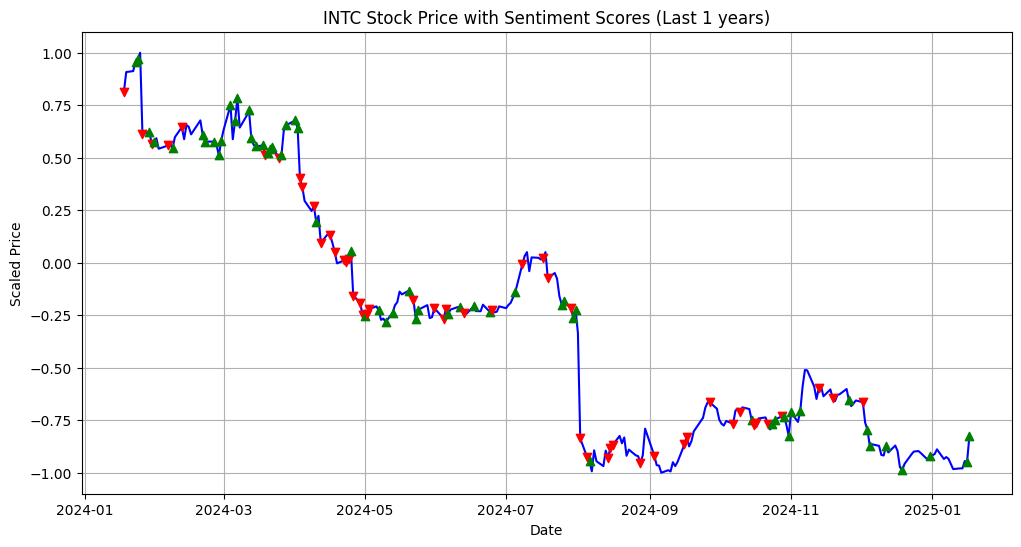

In [47]:
stock_data = yf.Ticker(stock)
prices = stock_data.history(period="1y")

min_price = prices['Close'].min()
max_price = prices['Close'].max()
scaled_prices = ((prices['Close'] - min_price) / (max_price - min_price) -0.5)*2

scaled_prices.index = [dt.date() for dt in scaled_prices.index]
scaled_prices.columns = ['Date','Price']

plt.figure(figsize=(12, 6))
plt.plot(scaled_prices.index, scaled_prices, label="Stock Price", color='blue')


for date, row in storeWithDateGroup.iterrows():
    
    if date in scaled_prices.index: 
        
        price = scaled_prices.loc[date]
        score = row['score']
        marker = '^' if score > 0 else 'v' if score < 0 else None
        color = 'g' if score > 0 else 'r' if score < 0 else None
        
        if color: 
            plt.scatter(date, price, color=color, marker=marker, label=f"Score: {score:.2f}", zorder=5)

# Formatting the plot
plt.title(f"{stock} Stock Price with Sentiment Scores (Last 1 years)")
plt.xlabel("Date")
plt.ylabel("Scaled Price")
plt.grid()
plt.show()


In [51]:
backTest = pd.DataFrame(columns = ['price', 'return',  'signal' ,'holdcash', 'holdstock','DCA', 'holdcashDCA', 'holdstockDCA', 'lumpSum', 'strategy'])

full_date_range = pd.date_range(start=prices.index[0], end=prices.index[-1])
backTest = backTest.reindex(full_date_range)

backTest['price'] = prices['Close']
backTest['price'] = backTest['price'].bfill().ffill()

backTest['return'] = backTest['price'].pct_change().fillna(0)

backTest['score'] = 0

backTest.index = [temp.date() for temp in pd.to_datetime(backTest.index)]

storeWithDateGroup.index = pd.to_datetime(storeWithDateGroup.index)
storeWithDateGroup['Signal'] = 0  # Default to no action
storeWithDateGroup.loc[storeWithDateGroup['score'] > 0, 'Signal'] = 1  # Buy if sentiment > 0
storeWithDateGroup.loc[storeWithDateGroup['score'] < 0, 'Signal'] = -1  # Sell if sentiment < 0

backTest['signal'] = storeWithDateGroup['Signal'].reindex(backTest.index).fillna(0)

INITIAL_CASH = 10000
backTest.loc[backTest.index[0],'holdcash'] = INITIAL_CASH
backTest.loc[backTest.index[0], 'holdstock'] = 0.0

DCA_AMOUNT = INITIAL_CASH / backTest.shape[0]
backTest.loc[backTest.index[0], 'holdcashDCA'] = INITIAL_CASH
backTest.loc[backTest.index[0], 'holdstockDCA'] = 0.0


backTest.loc[backTest.index[0],'lumpSum'] = INITIAL_CASH

for i in range(1, len(backTest)):
    ##############################################################################################################
    #STRATEGY
    # Update stock value based on return
    backTest.loc[backTest.index[i], 'holdstock'] = (
        backTest.loc[backTest.index[i - 1], 'holdstock'] * (1 + backTest.loc[backTest.index[i], 'return'])
    )
    
    if backTest.loc[backTest.index[i], 'signal'] == +1:
        # Buy logic
        numOfBuyShare = backTest.loc[backTest.index[i - 1], 'holdcash'] // backTest.loc[backTest.index[i], 'price']
        stock = numOfBuyShare * backTest.loc[backTest.index[i], 'price']
        backTest.loc[backTest.index[i], 'holdstock'] += stock
        backTest.loc[backTest.index[i], 'holdcash'] = backTest.loc[backTest.index[i - 1], 'holdcash'] - stock

    elif backTest.loc[backTest.index[i], 'signal'] == -1:
        # Sell logic
        toSell = backTest.loc[backTest.index[i - 1], 'holdstock']
        backTest.loc[backTest.index[i], 'holdcash'] = backTest.loc[backTest.index[i - 1], 'holdcash'] + toSell
        backTest.loc[backTest.index[i], 'holdstock'] = 0  # Reset stock after selling

    else:
        backTest.loc[backTest.index[i], 'holdcash'] = backTest.loc[backTest.index[i - 1], 'holdcash']
        backTest.loc[backTest.index[i], 'holdstock'] = backTest.loc[backTest.index[i - 1], 'holdstock']

    ##############################################################################################################
    #DCA
    backTest.loc[backTest.index[i], 'holdstockDCA'] = (
        backTest.loc[backTest.index[i - 1], 'holdstockDCA'] * (1 + backTest.loc[backTest.index[i], 'return'])
    )
    
    backTest.loc[backTest.index[i], 'holdcashDCA'] = backTest.loc[backTest.index[i-1], 'holdcashDCA'] - DCA_AMOUNT
    backTest.loc[backTest.index[i], 'holdstockDCA'] = backTest.loc[backTest.index[i], 'holdstockDCA'] + DCA_AMOUNT
    

    backTest.loc[backTest.index[i],'strategy'] = backTest.loc[backTest.index[i], 'holdstock'] + backTest.loc[backTest.index[i], 'holdcash']
    backTest.loc[backTest.index[i],'lumpSum'] = backTest.loc[backTest.index[i-1],'lumpSum'] * (1 + backTest.loc[backTest.index[i], 'return'])
    backTest.loc[backTest.index[i],'DCA'] = backTest.loc[backTest.index[i], 'holdstockDCA'] + backTest.loc[backTest.index[i], 'holdcashDCA']

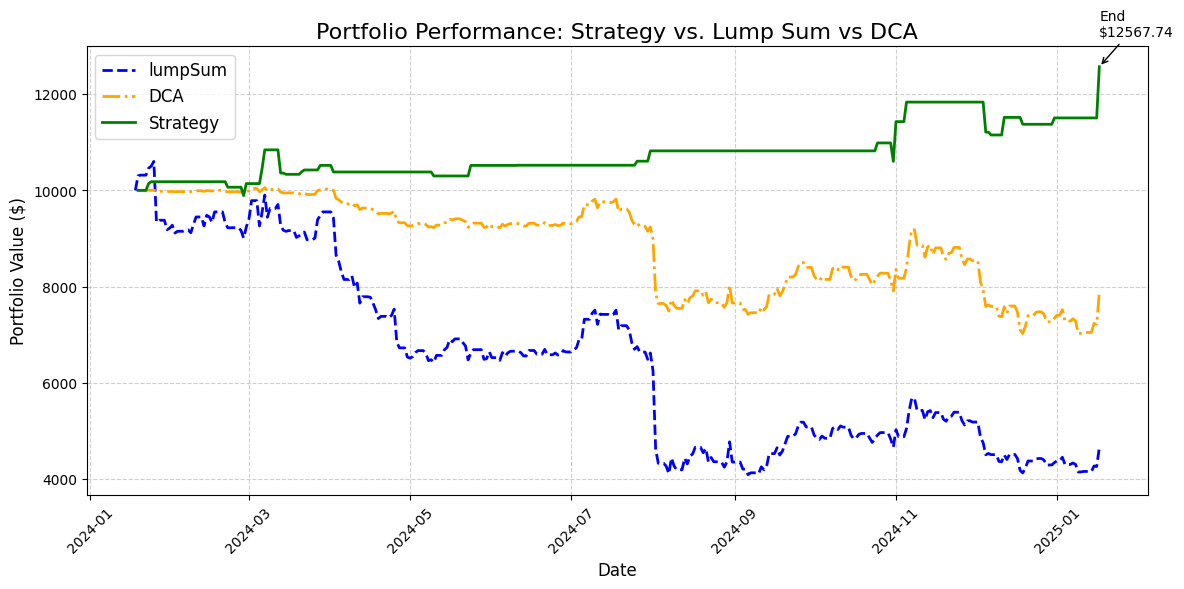

In [53]:
plt.figure(figsize=(12, 6))  # Set figure size for better visibility

plt.plot(backTest.index, backTest['lumpSum'], label='lumpSum', color='blue', linewidth=2, linestyle='--')
plt.plot(backTest.index, backTest['DCA'], label='DCA', color='orange', linewidth=2, linestyle='-.')
plt.plot(backTest.index, backTest['strategy'], label='Strategy', color='green', linewidth=2)

plt.title('Portfolio Performance: Strategy vs. Lump Sum vs DCA', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)

plt.grid(visible=True, linestyle='--', alpha=0.6)

plt.legend(fontsize=12, loc='upper left')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  
plt.xticks(rotation=45, fontsize=10) 


plt.annotate(f"End\n${backTest['strategy'].iloc[-1]:.2f}", 
             xy=(backTest.index[-1], backTest['strategy'].iloc[-1]), 
             xytext=(backTest.index[-1], backTest['strategy'].iloc[-1] * 1.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()



In [50]:
backTest

,price,return,signal,holdcash,holdstock,DCA,holdcashDCA,holdstockDCA,lumpSum,strategy,score
2024-01-18,46.122295,0.000000,-1.0,10000,0.0,NaN,10000,0.0,10000,NaN,0
2024-01-19,47.513657,0.030167,0.0,10000,0.0,10000.0,9972.677596,27.322404,10301.667821,10000.0,0
2024-01-20,47.582733,0.001454,0.0,10000,0.0,10000.039722,9945.355191,54.684531,10316.644643,10000.0,0
2024-01-21,47.582733,0.000000,1.0,7.626038,9992.373962,10000.039722,9918.032787,82.006935,10316.644643,10000.0,0
2024-01-22,47.582733,0.000000,0.0,7.626038,9992.373962,10000.039722,9890.710383,109.329339,10316.644643,10000.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13,19.200001,0.000000,0.0,11504.856905,0,7049.059185,136.612022,6912.447164,4162.845887,11504.856905,0
2025-01-14,19.200001,0.000000,0.0,11504.856905,0,7049.059185,109.289617,6939.769568,4162.845887,11504.856905,0
2025-01-15,19.719999,0.027083,0.0,11504.856905,0,7237.010746,81.967213,7155.043533,4275.589311,11504.856905,0
2025-01-16,19.670000,-0.002535,1.0,17.57686,11487.280045,7218.869431,54.644809,7164.224623,4264.748733,11504.856905,0
